## Apple Product Sentiment Analysis

### by Monica Pecha, Sam Choe, and Daniel Fox

### Overview

This project analyzes--

### Business Understanding

### Data Limitations

### Table of Contents

### Exploratory Data Analysis (EDA)

In [1]:
# Bringing in packages for EDA, pre-processing, modeling, and visualizations
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix, recall_score
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Reading in the original dataset
df = pd.read_csv("data/judge-1377884607_tweet_product_company.csv", encoding="ISO-8859-1")

In [3]:
df.head(20)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
df["emotion_in_tweet_is_directed_at"].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
df["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [7]:
df["tweet_text"].iloc[4]

"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"

In [8]:
# Defining keywords to diferentiate between Google and Apple product tweets
apple_keywords = ['iPad', 'IPad', 'i-Pad', 'IPAD', 'iphone', 'iPhone', 'Iphone', 'i-phone', 'I-Phone', 'Apple', 'apple', 'Ipad', 'ipad', 'iTunes','Mac', 'IPhone', 'IPHONE']
google_keywords = ['google', 'android', 'Google', 'Android', 'samsung', 'GOOGLE']

def find_brand(text):
    if isinstance(text, str):
        for word in apple_keywords:
            if word in text:
                return "Apple" 
        for word in google_keywords:
            if word in text:
                return "Google" 
    return 'No_Product'

df['product'] = df['tweet_text'].apply(find_brand)

In [9]:
df['product'].value_counts()

Apple         5587
Google        2771
No_Product     735
Name: product, dtype: int64

In [10]:
# Looking for null values in 'product'
df['product'].isna().sum()

0

In [11]:
df['product'].head()

0     Apple
1     Apple
2     Apple
3     Apple
4    Google
Name: product, dtype: object

In [12]:
# Converting strings to integers and combining 'neutral'/'no emotion toward brand or product' with 'unknown'/'I can't tell'
# 0 = negative, 1 = neutral, and 2 = positive
# Renaming 'is_there_an_emotion_directed_at_a_brand_or_product' to 'emotion'
mapping = {"Positive emotion": 2, "No emotion toward brand or product": 1, "I can't tell": 1, "Negative emotion": 0}
df['emotion'] = df["is_there_an_emotion_directed_at_a_brand_or_product"].map(mapping)

In [13]:
df["emotion"].value_counts()

1    5545
2    2978
0     570
Name: emotion, dtype: int64

In [14]:
#use 1 to show all info in cell below then comment it out and use 2 to go back to default view
#1
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

#2
#pd.reset_option('display.max_rows')
#pd.reset_option('display.max_colwidth')

In [15]:
#exploring 'No_Product' tweets
filtered_df = df[df['product'] == 'No_Product']

print(filtered_df['tweet_text'])

6                                                                                                                                                                  NaN
51                                    ÛÏ@mention {link} &lt;-- HELP ME FORWARD THIS DOC to all Anonymous accounts, techies,&amp; ppl who can help us JAM #libya #SXSW
52                                                                                     ÷¼ WHAT? ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter
53                                                                        .@mention @mention on the location-based 'fast, fun and future' - {link} (via @mention #sxsw
65                       Agree. RT @mention Wait. FIONA APPLE is in town??? Somebody kidnap her and put her in a recording studio until she records a new album. #sxsw
66                                                                            At #sxsw? @mention / @mention wanna buy you a drink. 7pm at Fado on 4th. {link} Join us

In [16]:
print(df['tweet_text'][65])
print(df['tweet_text'][3079])
print(df['tweet_text'][4478])
#ill have to manually sort these

Agree. RT @mention Wait. FIONA APPLE is in town??? Somebody kidnap her and put her in a recording studio until she records a new album. #sxsw
Can I tweet this if I only use APPLE :) RT @mention Microsoft's DPE will b SXSWi &amp; Tweeting @mention #microsoft &amp; #sxsw
Wait. FIONA APPLE is in town??? Somebody kidnap her and put her in a recording studio until she records a new album. #sxsw


In [105]:
#not sure about this prob nothing
print(df.iloc[65])

tweet_text                                            Agree. RT @mention Wait. FIONA APPLE is in town??? Somebody kidnap her and put her in a recording studio until she records a new album. #sxsw
emotion_in_tweet_is_directed_at                                                                                                                                                                 NaN
is_there_an_emotion_directed_at_a_brand_or_product                                                                                                               No emotion toward brand or product
product                                                                                                                                                                                  No_Product
emotion                                                                                                                                                                                           1
Name: 65, dtype: obj

In [18]:
df2 = df[["tweet_text", "product", "emotion"]]

In [19]:
#df2_google = df2[df2['product'] == "Google"]

In [20]:
#df2_google.head()

In [21]:
# Creating an Apple product only dataframe
df2_apple = df2[df2['product'] == "Apple"]

In [22]:
df2_apple.head()

,tweet_text,product,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Apple,0
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Apple,2
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Apple,2
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Apple,0
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,Apple,1


In [23]:
df2_apple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5587 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  5587 non-null   object
 1   product     5587 non-null   object
 2   emotion     5587 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 174.6+ KB


In [24]:
# The emotion in the dataset in not balanced
df2_apple["emotion"].value_counts(normalize=True)

1    0.540720
2    0.383748
0    0.075532
Name: emotion, dtype: float64

#### In order to address the "emotion" class inbalance we attempted to scrape down tweets about Apple products with negative sentiment, see code and 'Forbidden' message below preventing the scraping. [Needs editing and formatting]

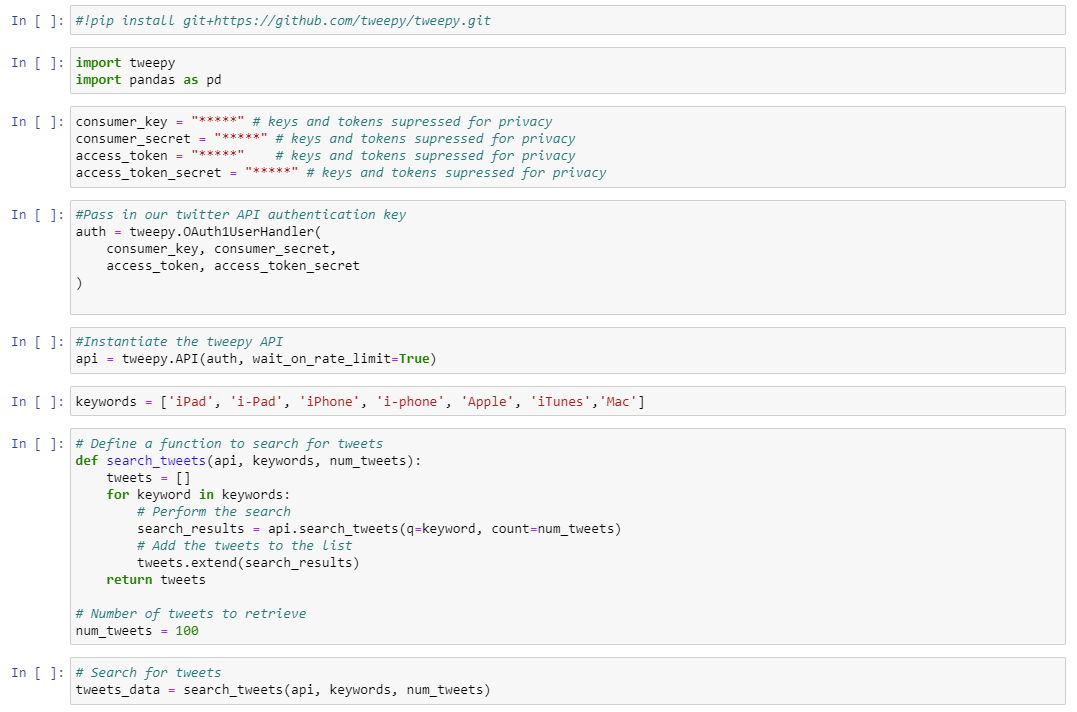

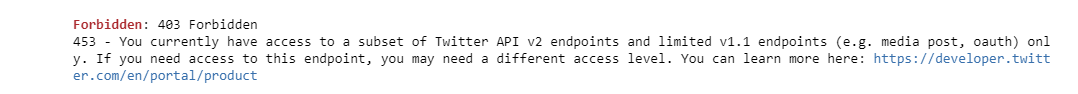

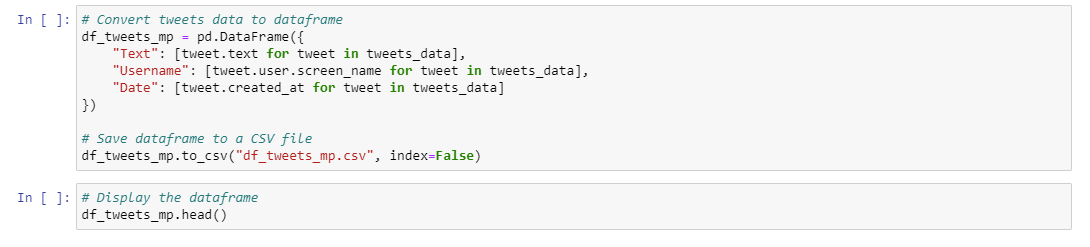

In [25]:
# In order to address the class imbalance we generated tweets with negative sentiment regarding Apple products using ChatGPT
df_new_tweets = pd.read_excel("data/Tweets_SyntheticGeneration_20240503.xlsx")

In [26]:
# The new ChatGPT tweets
df_new_tweets

,Unnamed: 0,Unnamed: 1
0,"1. ""Bought the latest iPhone, and it's already glitching. Apple, you really need to get your act together! #disappointed""","""Bought the latest iPhone, and it's already glitching. Apple, you really need to get your act together! #disappointed"""
1,"1. ""Just got the new iPhone, and it's already crashing apps left and right. Seriously, Apple, get your act together! #frustrated""",NaN
2,"1. ""Just tried out the original iPhone... what a disappointment! The touch screen is so unresponsive, and the camera quality is terrible. Can't believe people actually bought into this hype. #iPhone #fail""",NaN
3,"1. ""Just tried the iPad 2 at #SXSW... disappointed doesn't even begin to describe it. Same old design, same old issues. #iPad2 #letdown""",NaN
4,"1. ""The iPod Nano 3rd Generation was a disappointment. Sure, it had video playback, but the lack of camera and the square design made it awkward to use, and the battery life was poor. #iPodNano3 #disappointing""",NaN
5,"1. ""The Power Mac G4 Cube may look cool, but it's loud, slow, and prone to overheating. Definitely not worth the investment. #PowerMacG4Cube #disappointed""",NaN
6,"1. Just got the latest iPhone, and it's already slower than my old one. Thanks, Apple. #SlowPhone",NaN
7,1. Just had my daily dose of frustration trying to connect my iPhone to my MacBook. Can these devices not communicate or what?,NaN
8,"1. Just when I thought my MacBook couldn't get any slower, it decides to take a coffee break every time I open an app. #MacBookMeltdown",NaN
9,"1. Just when I thought my MacBook keyboard couldn't get any worse, it decides to malfunction on a deadline day. Thanks for the stress, Apple. #KeyboardNightmare",NaN


In [27]:
df_new_tweets.columns = ['tweet_text', 'extra_col']

In [28]:
# ChatGPT generated several duplicate tweets that we then removed from the dataset
df_new_tweets_clean = df_new_tweets.drop_duplicates(subset='tweet_text')

In [29]:
df_new_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1719 entries, 0 to 1767
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  1719 non-null   object
 1   extra_col   1 non-null      object
dtypes: object(2)
memory usage: 40.3+ KB


In [30]:
df_new_tweets_clean['product'] = 'Apple'

<ipython-input-30-55661c2f5466>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_tweets_clean['product'] = 'Apple'


In [31]:
df_new_tweets_clean.head()

,tweet_text,extra_col,product
0,"1. ""Bought the latest iPhone, and it's already glitching. Apple, you really need to get your act together! #disappointed""","""Bought the latest iPhone, and it's already glitching. Apple, you really need to get your act together! #disappointed""",Apple
1,"1. ""Just got the new iPhone, and it's already crashing apps left and right. Seriously, Apple, get your act together! #frustrated""",NaN,Apple
2,"1. ""Just tried out the original iPhone... what a disappointment! The touch screen is so unresponsive, and the camera quality is terrible. Can't believe people actually bought into this hype. #iPhone #fail""",NaN,Apple
3,"1. ""Just tried the iPad 2 at #SXSW... disappointed doesn't even begin to describe it. Same old design, same old issues. #iPad2 #letdown""",NaN,Apple
4,"1. ""The iPod Nano 3rd Generation was a disappointment. Sure, it had video playback, but the lack of camera and the square design made it awkward to use, and the battery life was poor. #iPodNano3 #disappointing""",NaN,Apple


In [32]:
import re # importing regular expressions

In [33]:
# Define a regular expression pattern to match any number followed by a period and a space
pattern = r'^\d+\.\s'

In [34]:
# Need to remove the numbers in front of the tweets
df_new_tweets_clean['tweet_text'][3]

'1. "Just tried the iPad 2 at #SXSW... disappointed doesn\'t even begin to describe it. Same old design, same old issues. #iPad2 #letdown"'

In [35]:
# Iterate through the dataframe column and remove the matching pattern using regex
df_new_tweets_clean['tweet_text'] = df_new_tweets_clean['tweet_text'].map(lambda x: re.sub(pattern, '', x))

<ipython-input-35-4be8770b532e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_tweets_clean['tweet_text'] = df_new_tweets_clean['tweet_text'].map(lambda x: re.sub(pattern, '', x))


In [36]:
df_new_tweets_clean.head()

,tweet_text,extra_col,product
0,"""Bought the latest iPhone, and it's already glitching. Apple, you really need to get your act together! #disappointed""","""Bought the latest iPhone, and it's already glitching. Apple, you really need to get your act together! #disappointed""",Apple
1,"""Just got the new iPhone, and it's already crashing apps left and right. Seriously, Apple, get your act together! #frustrated""",NaN,Apple
2,"""Just tried out the original iPhone... what a disappointment! The touch screen is so unresponsive, and the camera quality is terrible. Can't believe people actually bought into this hype. #iPhone #fail""",NaN,Apple
3,"""Just tried the iPad 2 at #SXSW... disappointed doesn't even begin to describe it. Same old design, same old issues. #iPad2 #letdown""",NaN,Apple
4,"""The iPod Nano 3rd Generation was a disappointment. Sure, it had video playback, but the lack of camera and the square design made it awkward to use, and the battery life was poor. #iPodNano3 #disappointing""",NaN,Apple


In [37]:
df2_apple.head()

,tweet_text,product,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Apple,0
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Apple,2
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Apple,2
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Apple,0
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,Apple,1


In [38]:
df_combo = pd.concat([df2_apple, df_new_tweets_clean], axis=0)

In [39]:
columns_to_drop = ['extra_col', 'emotion']
df_combo.drop(columns=columns_to_drop, inplace=True)

In [40]:
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7306 entries, 0 to 1767
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  7306 non-null   object
 1   product     7306 non-null   object
dtypes: object(2)
memory usage: 171.2+ KB


Implementing VADER on the emotion column

In [41]:
#!pip install vaderSentiment

In [42]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Assuming df is your DataFrame with tweet texts
# Example:
# df = pd.DataFrame({'tweet_text': ["I love this place!", "This movie is terrible.", "Feeling neutral about this weather."]})

# Drop NaN values or replace with empty strings (MP-do we need this?)
df_combo['tweet_text'].fillna('', inplace=True)

# Analyze sentiment for each tweet and add the scores to the DataFrame
df_combo['sentiment'] = df_combo['tweet_text'].apply(lambda tweet: analyzer.polarity_scores(tweet))

# Extract compound sentiment score from the sentiment dictionary
df_combo['compound_score'] = df_combo['sentiment'].apply(lambda score_dict: score_dict['compound'])

# Function to categorize compound score into positive, negative, or neutral
def categorize_sentiment(score):
    if score > 0.05:
        return '2'
    elif score < -0.05:
        return '0'
    else:
        return '1'

# Apply the function to create a new column with sentiment category
df_combo['emotion'] = df_combo['compound_score'].apply(categorize_sentiment)

# Print or use the DataFrame as per your requirement
print(df_combo[['tweet_text', 'compound_score', 'emotion']])

                                                                                                                                                                                                                                 tweet_text  \
0                                                                                                           .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1                                                                                               @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                                                                                                                           @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                           

In [43]:
df_combo.head()

,tweet_text,product,sentiment,compound_score,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Apple,"{'neg': 0.173, 'neu': 0.827, 'pos': 0.0, 'compound': -0.68}",-0.6800,0
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Apple,"{'neg': 0.0, 'neu': 0.59, 'pos': 0.41, 'compound': 0.91}",0.9100,2
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Apple,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,1
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Apple,"{'neg': 0.0, 'neu': 0.681, 'pos': 0.319, 'compound': 0.7269}",0.7269,2
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,Apple,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,1


In [44]:
df_combo["emotion"].value_counts()

2    2942
1    2571
0    1793
Name: emotion, dtype: int64

In [45]:
df_combo['emotion']=df_combo['emotion'].astype(np.int64)

In [46]:
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7306 entries, 0 to 1767
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      7306 non-null   object 
 1   product         7306 non-null   object 
 2   sentiment       7306 non-null   object 
 3   compound_score  7306 non-null   float64
 4   emotion         7306 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 342.5+ KB


In [47]:
df_combo_neg_sample = df_combo[df_combo['emotion'] == 0].sample(n=1500)
df_combo_neutral_sample = df_combo[df_combo['emotion'] == 1].sample(n=1500)
df_combo_pos_sample = df_combo[df_combo['emotion'] == 2].sample(n=1500)

In [48]:
df_combo_neg_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 1329 to 291
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      1500 non-null   object 
 1   product         1500 non-null   object 
 2   sentiment       1500 non-null   object 
 3   compound_score  1500 non-null   float64
 4   emotion         1500 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 70.3+ KB


In [49]:
df_combo_neg_sample['emotion'].value_counts()

0    1500
Name: emotion, dtype: int64

In [50]:
df_combo_sample = pd.concat([df_combo_neg_sample, df_combo_neutral_sample, df_combo_pos_sample], axis=0)

In [51]:
df_combo_sample.head()

,tweet_text,product,sentiment,compound_score,emotion
1329,"""The iPod Nano 1st Generation was a disappointment. Sure, it was small, but the lack of storage options and the monochrome display made it outdated, and the battery life was poor. #iPodNano1 #disappointing""",Apple,"{'neg': 0.314, 'neu': 0.648, 'pos': 0.038, 'compound': -0.9169}",-0.9169,0
4043,"Msft panel on touch interfaces shows a bunch of tablets, but no iPad #sxsw #DontBeHatin",Apple,"{'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'compound': -0.4215}",-0.4215,0
3531,"Crap, might need to bring the AMEX now. RT @mention Apple to Open Pop-Up Shop at SXSW [REPORT] - {link} #sxsw",Apple,"{'neg': 0.115, 'neu': 0.885, 'pos': 0.0, 'compound': -0.3818}",-0.3818,0
1137,"""Just tried the iPad... it's too bulky to be truly portable. Disappointing design, Apple. #iPad #disappointed #SXSW""",Apple,"{'neg': 0.272, 'neu': 0.603, 'pos': 0.125, 'compound': -0.5267}",-0.5267,0
1220,"""The MacBook Air sacrifices too much for thinness. Not worth the compromise. #MacBookAir #letdown #SXSW""",Apple,"{'neg': 0.106, 'neu': 0.894, 'pos': 0.0, 'compound': -0.1695}",-0.1695,0


In [52]:
df_combo_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 1329 to 2832
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      4500 non-null   object 
 1   product         4500 non-null   object 
 2   sentiment       4500 non-null   object 
 3   compound_score  4500 non-null   float64
 4   emotion         4500 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 210.9+ KB


In [53]:
df_combo_sample['emotion'].value_counts(normalize=True)

2    0.333333
1    0.333333
0    0.333333
Name: emotion, dtype: float64

In [54]:
columns_to_drop = ['sentiment', 'compound_score', 'product']
df_combo_sample.drop(columns=columns_to_drop, inplace=True)

### Moving into pre processing

In [55]:
# Defining X and y
X=df_combo_sample["tweet_text"]
y=df_combo_sample["emotion"]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.2)

In [57]:
sw = stopwords.words('english')

In [108]:
# Adding stopwords based on the dataset
sw.extend(["sxsw", "mention", "rt", "link", "new", "get", "line", "go", "use", "one", "via", "need", "would", "try", "come", "day", "give", "see", "know", "sxswi", "th", "even", "guy", "say"])

In [109]:
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [110]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [111]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [112]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X_train]

In [113]:
token_tweets

['hard time tweet use iphone use ipad much good hisxsw',
 'apple watch remind close exercise ring busy binge watch netflix thanks guilt trip apple watchwoes',
 'wonder many back ipad maybe everyone',
 'speak apple store congress great permanent',
 'less hour apple store ipad',
 'get power mac g letdown overpriced prone overheat lack software optimization make slow powermacg disappoint',
 'anybody trouble download pak app iphone',
 'outside pop apple store crazy long festival get entertain every',
 'couple blog random tip awesome iphone app dev politics behind html',
 'temporary apple store open amp congress tomorrow ipad',
 'amazes many people tuck flap apple ipad case',
 'go mock tech nerd come stand hour ipad remember horror movie',
 'macbook pro overhyped underperforms macbookpro disappointed',
 'g iphone hr tweet rise austin dead upgrade plugin station',
 'ipod nano gen screen small enjoy anything ipodnano letdown',
 'less hour announce detail ipad giveaway',
 'macbook pro overhype

#### chosing count vectorizer because we are less concerned about weighting words that are unique in the corpus.

In [114]:
X_train.head()

5963                                   RT @mention Having a hard time tweeting and using iPhone here at #SXSW. Using iPad and it's much better. #HISXSW
360     Apple Watch: reminding me I haven't closed my exercise ring while I'm busy binge-watching Netflix. Thanks for the guilt trip, Apple. #WatchWoes
6910                                             RT @mention We're wondering how many @mention will come back from #sxsw with iPad 2's. Maybe everyone?
4910                              Speaking of #sxsw: how about that #apple store on 6th and congress? Wouldn't it be great if it were permanent....? ;)
3406                                      In less than 24 hours, this will be an Apple Store: {link} (And this will be the line in: {link} #sxsw #ipad2
Name: tweet_text, dtype: object

In [115]:
#consider putting a pipleine here--

In [116]:
cv=CountVectorizer()

In [117]:
X_train_vec = cv.fit_transform(token_tweets)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [118]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X_test]

In [119]:
X_test_vec = cv.transform(token_tweets_test)
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)

In [120]:
X_train_vec.head()

,aapl,aber,able,abnormal,absolutely,absolutley,absurd,abt,abysmal,acc,...,zeldman,zero,zimride,zip,zite,zms,zomg,zone,zuckerberg,zynga
5963,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
mnb = MultinomialNB()

In [122]:
mnb.fit(X_train_vec, y_train)

MultinomialNB()

In [123]:
y_pred=mnb.predict(X_test_vec)

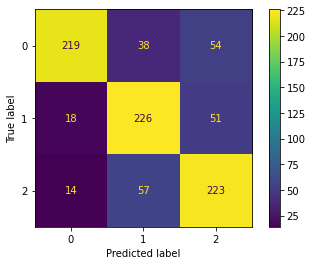

In [124]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(mnb, X_test_vec, y_test )

In [125]:
accuracy_score(y_test, y_pred)

0.7422222222222222

In [126]:
precision_score(y_test, y_pred, average='weighted')

0.7543660533342994

In [127]:
recall_score(y_test, y_pred, average='weighted')

0.7422222222222222

In [148]:
from collections import Counter
import pandas as pd

# Assuming X_train_vec is your vectorized dataset (e.g., using CountVectorizer)
word_frequencies = X_train_vec.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(30)

# Print the most common words and their frequencies
print(most_common_words)

            Frequency
Word                 
ipad             1548
apple            1419
iphone           1126
store             688
quot              442
austin            368
app               311
letdown           264
pop               260
macbook           245
disappoint        240
open              229
ipod              220
amp               209
design            184
make              162
like              162
get               135
time              135
launch            128
think             128
temporary         122
screen            122
battery           116
win               113
free              112
go                106
android           103
downtown          100
lack               98


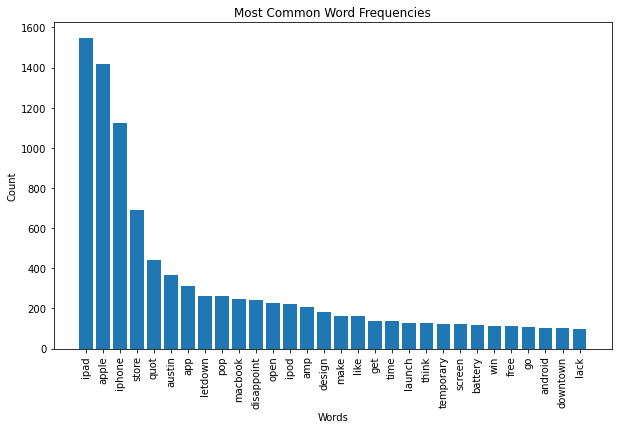

In [129]:
# Extract words and their counts from most_common_words DataFrame
most_common_words = word_frequencies_df.head(30)
words = most_common_words.index
counts = most_common_words['Frequency']

plt.figure(figsize=(10, 6))
plt.bar(range(len(words)), counts, tick_label=words)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Most Common Word Frequencies')
plt.xticks(rotation=90)
plt.show()

In [154]:
from wordcloud import WordCloud

# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

AttributeError: 'TransposedFont' object has no attribute 'getbbox'

#### trying a TF-IDF vector instead of a count - just because. Need to change the name 'X_train_vec'? Use the same name with the count vectorizer?

In [130]:
tfidf = TfidfVectorizer(encoding="ISO-8859-1")

In [131]:
X_train_vec_tfidf = tfidf.fit_transform(token_tweets)
X_train_vec_tfidf = pd.DataFrame.sparse.from_spmatrix(X_train_vec_tfidf)
X_train_vec_tfidf.columns = sorted(tfidf.vocabulary_)
X_train_vec_tfidf.set_index(y_train.index, inplace=True)

In [132]:
# can delete this; created above
# token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X_test]

In [133]:
X_test_vec_tfidf = tfidf.transform(token_tweets_test)
X_test_vec_tfidf = pd.DataFrame.sparse.from_spmatrix(X_test_vec_tfidf)
X_test_vec_tfidf.columns = sorted(tfidf.vocabulary_)
X_test_vec_tfidf.set_index(y_test.index, inplace=True)

In [134]:
X_train_vec_tfidf.head()

,aapl,aber,able,abnormal,absolutely,absolutley,absurd,abt,abysmal,acc,...,zeldman,zero,zimride,zip,zite,zms,zomg,zone,zuckerberg,zynga
5963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
mnb2 = MultinomialNB()

In [136]:
mnb2.fit(X_train_vec_tfidf, y_train)

MultinomialNB()

In [137]:
y_pred2=mnb2.predict(X_test_vec_tfidf)

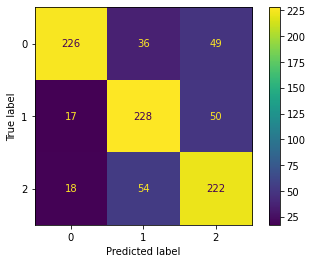

In [138]:
cm2 = confusion_matrix(y_test, y_pred2)
plot_confusion_matrix(mnb2, X_test_vec_tfidf, y_test );

In [89]:
# metrics here - accurary, precision, recall

In [141]:
accuracy_score(y_test, y_pred2)

0.7511111111111111

In [142]:
precision_score(y_test, y_pred2, average='weighted')

0.7601461732478784

In [143]:
recall_score(y_test, y_pred2, average='weighted')

0.7511111111111111

In [144]:
# Assuming X_train_vec is your vectorized dataset (e.g., using CountVectorizer)
word_frequencies_tfidf = X_train_vec_tfidf.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df2 = pd.DataFrame(word_frequencies_tfidf, columns=['Frequency'])
word_frequencies_df2.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df2 = word_frequencies_df2.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words2 = word_frequencies_df2.head(30)

# Print the most common words and their frequencies
print(most_common_words2)

               Frequency
Word                    
ipad          194.744517
apple         188.397584
iphone        156.064907
store         137.810952
quot           88.375315
austin         84.402333
pop            68.690883
open           64.804443
app            64.488396
letdown        61.660085
macbook        59.497991
disappoint     57.250871
ipod           52.647099
design         44.717989
amp            42.663663
temporary      41.964628
launch         38.920678
make           37.817305
like           36.457395
downtown       34.851912
time           34.760360
think          34.154069
get            34.038182
win            32.635525
screen         32.340689
popup          31.504395
outdated       29.263354
free           29.006649
disappointed   28.363690
try            28.001061


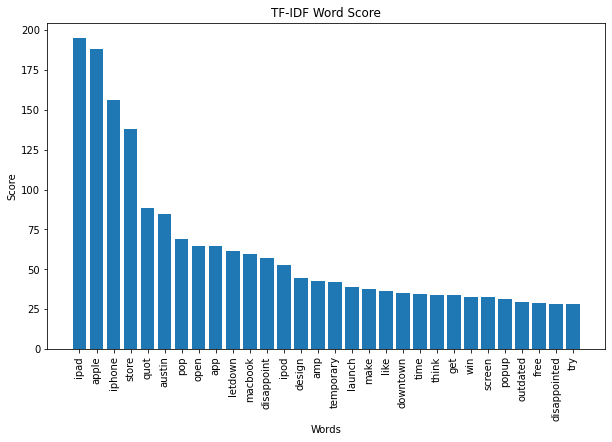

In [145]:
# Extract words and their counts from most_common_words DataFrame
most_common_words2= word_frequencies_df2.head(30)
words = most_common_words2.index
counts = most_common_words2['Frequency']

plt.figure(figsize=(10, 6))
plt.bar(range(len(words)), counts, tick_label=words)
plt.xlabel('Words')
plt.ylabel('Score')
plt.title('TF-IDF Word Score')
plt.xticks(rotation=90)
plt.show()

In [146]:
grid = {'n_estimators': [500, 1000, 1500],
       'max_depth': [8, 10, 12, 14],
        'max_features': [3, 6, 9]
                }

In [147]:
rf_clf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf_clf, param_grid=grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vec, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 10, 12, 14],
                         'max_features': [3, 6, 9],
                         'n_estimators': [500, 1000, 1500]},
             scoring='accuracy')

In [150]:
grid_search.best_params_

{'max_depth': 14, 'max_features': 6, 'n_estimators': 1500}

In [ ]:
grid_search.best_score_

In [151]:
rf = RandomForestClassifier(n_estimators=1500, max_features=6, max_depth=14)
rf.fit(X_train_vec, y_train)
y_pred = rf.predict(X_test_vec)
precision_score(y_test, y_pred, average="weighted")

0.7962344760791868

In [ ]:
#create frequency distribution, other possible visuals?

Monica's notes to self

- pipeline
- rf girdsearch
- freq distributions
- other vectorizer


- combine emotion_in_tweet_is_directed_at into two options (apple and google)
- drop row 6 - missing tweet (don't need to if just focusing on Apple)
- update is_there_an_emotion_directed_at_a_brand_or_product to numeric (0=neg, 1=neutral, 2=pos)
- consider adding SWSW to stop words 
- look at @, is it dropped in punctuation. do we want it dropped?
- look at #?

- used Vader, but it did not seem to classify well after spot checking
- explored using an API to pull down additional SXSW product data

- Additional notes: Sansung and Android included with Google
- do we want to delete google specific dataframe?


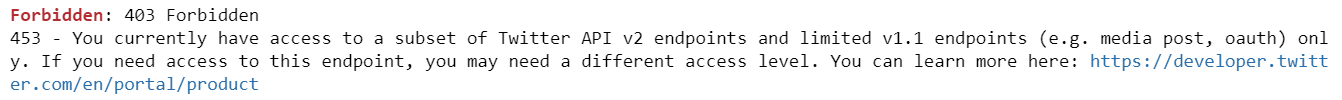
